In [1]:
from os import path
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.vq import vq, kmeans
from matplotlib.patches import Patch, Ellipse
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

In [2]:
# Importing data
wd = "/Users/viniWS/Bio/synecho/"
df = pd.read_csv(path.join(wd, "data/Synechococcus_metadata_table.csv"))

In [3]:
# Adding quality filter based on criteria
df["Quality Filter"] = df.apply(lambda row: "Passed (144)" if row["Size"] > 1.0 and row["Completeness"] > 50.0 else "Failed (27)", axis=1)

In [4]:
# Let's use only genomes which passed the criteria for downstream analyses
df = df[df["Quality Filter"] == "Passed (144)"].iloc[:, 1:]

In [5]:
df["Organism"] = df["Organism"].apply(lambda s: s.replace("_", " "))

In [6]:
df["Proposed Name"] = df["New_Genus"] + " " + df["New_Species"]

In [7]:
# Generating Table_S1. Uncomment if you want to overwrite.

# df[[
#     "Organism",
#     "Strain",
#     "Proposed Name",
#     "Completeness",
#     "Contamination",
#     "Size",
#     "GC",
#     "Assembly",
#     "BioSample",
#     "BioProject",
#     "Release Date",
#     "Modify Date",
# ]].to_excel("../../Table_S1.xls", index=False)

In [8]:
# Adding column of number of genomes per genus and species
df["No_genus"] = df.groupby('New_Genus')['New_Genus'].transform('count').map(int, na_action="ignore")
df["No_species"] = df.groupby('New_Species')['New_Species'].transform('count').map(int, na_action="ignore")

# Adding a formatted name to use in your legends
df["name_fmt"] = df["New_Genus"] + " ("+ df["No_genus"].map(int, na_action="ignore").map(str) + ")"
df["name_fmt_"] = df["New_Species"] + " ("+ df["No_species"].map(int, na_action="ignore").map(str) + ")"

In [10]:
def raw(str):
    return r'${}$'.format(str)

In [11]:
df["name_fmt2"] = df["name_fmt"].apply(lambda s: str(s).replace("Synechospongium", "Synechospongium\ \mathrm{gen. nov.}"))
df["name_fmt2"] = df["name_fmt2"].apply(lambda s: str(s).replace("Lacustricoccus", "Lacustricoccus\ \mathrm{gen. nov.}"))
df["name_fmt2"] = df["name_fmt2"].apply(lambda s: raw(str(s).replace(" (", "\ (")))

In [12]:
# Removing genomes with only 1 genus
df = df[df["No_genus"].apply(lambda n: int(n) > 1)]

Text(0, 0.5, '')

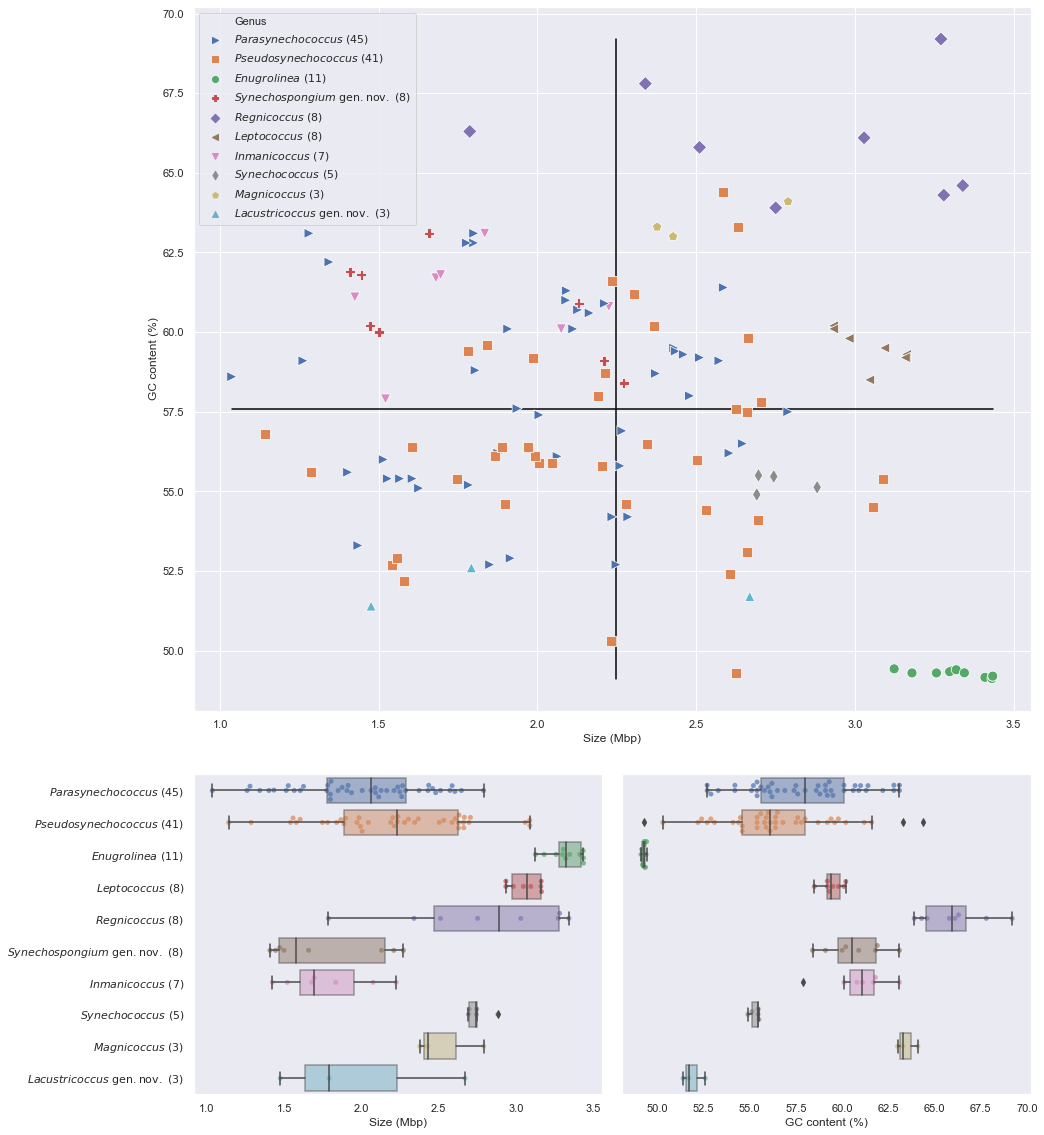

In [15]:
# Large plot
fig = plt.figure(figsize=(15, 20))

gs = GridSpec(
    nrows=3, ncols=2, height_ratios=[1,1,1], wspace=0.05
)

max_s, min_s, median_s = max_s, min_s, median_s = df["Size"].max(), df["Size"].min(), df["Size"].median()
max_gc, min_gc, median_gc = df["GC"].max(), df["GC"].min(), df["GC"].median()
order = list(df["name_fmt2"].value_counts().index)
filled_markers = ('o', 'v', '^', '<', 'p', '>', 's', 'D', 'd', 'P', 'X', )

# Scatter plot
ax0 = fig.add_subplot(gs[:2, :])
ax0.plot([max_s, min_s], [median_gc, median_gc], color="black", zorder=1)
ax0.plot([median_s, median_s], [max_gc, min_gc], color="black", zorder=1)
sns.scatterplot(
            x="Size",
            y="GC",
            data=df.sort_values(
                by="No_genus", ascending=False
            ),
            hue=df["name_fmt2"],
            style=df["name_fmt2"],
            hue_order=order,
            s=100,
            zorder=2,
            markers=filled_markers,
            ax=ax0,
            palette=sns.color_palette()
        )
legend = ax0.legend()
legend.texts[0].set_text("Genus")

# Size plot
ax1 = fig.add_subplot(gs[2, 0])
sns.boxplot(
    y="name_fmt2",
    x="Size",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
    boxprops=dict(alpha=.5),
    ax=ax1)
sns.swarmplot(
    y="name_fmt2",
    x="Size",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
        hue="name_fmt2",
    alpha=0.7,
    zorder=0,
    ax=ax1)

# GC plot
ax2 = fig.add_subplot(gs[2, 1], sharey=ax1)
sns.boxplot(
    y="name_fmt2",
    x="GC",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
    boxprops=dict(alpha=.5),
    ax=ax2)
sns.swarmplot(
    y="name_fmt2",
    x="GC",
    data=df.sort_values(
        by="No_genus", ascending=False)
    ,
    hue="name_fmt2",
    alpha=0.7,
    zorder=0,
    ax=ax2)


# Hiding legends
plt.setp(ax2.get_yticklabels(), visible=False)
ax1.legend().remove()
ax2.legend().remove()
ax1.grid(False)
ax2.grid(False)

# Fixing labels
ax0.set_xlabel("Size (Mbp)")
ax0.set_ylabel("GC content (%)")
ax1.set_xlabel("Size (Mbp)")
ax1.set_ylabel("")
ax2.set_xlabel("GC content (%)")
ax2.set_ylabel("")

# plt.savefig(path.join(wd,"Figure_1_concat.png"), dpi=700, bbox_inches="tight",)